![image.png](https://i.imgur.com/a3uAqnb.png)

# Image Generation using Autoencoder: MNIST
- **Images**: Handwritten digits **(28x28, grayscale)**.
- **Classes**: 10 digit classes (0-9), but for Autoencoder we **ignore labels**.
- **Shape**: `(batch_size, 1, 28, 28)` → 1 grayscale channel.
  
![MNIST image](https://i.imgur.com/TQlKspY.png)


## 1️⃣ Dataset Class

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define transformations (convert to tensor)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
])

# Load MNIST dataset
train_dataset = MNIST(root="./datasets", train=True, transform=transform, download=True)
#we didn't write test_dataset because it's unsupervised learning so we don't have labels for images, MNIST data.

# Create DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#we didn't write test_dataset because it's unsupervised learning so we don't have labels for images

# Check dataset size
print(f"Training samples: {len(train_dataset)}")


Training samples: 60000


### Let's display some images

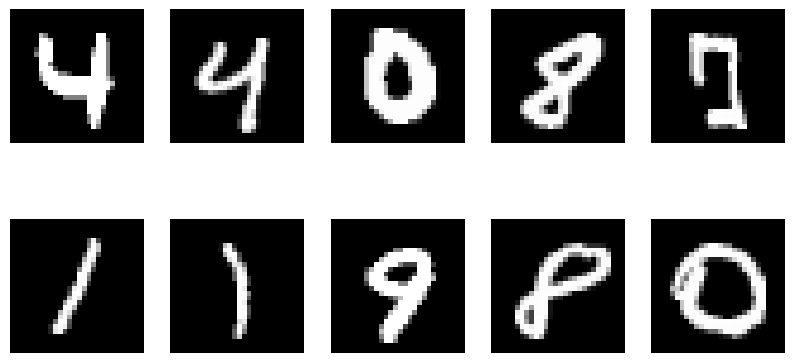

Shape of one image tensor: torch.Size([1, 28, 28])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)  # Labels are ignored in Autoencoder

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze(0)  # Remove channel dimension (1, 28, 28) → (28, 28)
    #we can use permute instead

    ax.imshow(img.numpy(), cmap="gray") #transfer it to numby then display it
    ax.axis("off")

plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (1, 28, 28)


## 2️⃣ Model Class

# **📌 Autoencoder Model**
An **Autoencoder** is a type of neural network that learns to **compress (encode) and reconstruct (decode) input data**.

## **🔹 Model Structure**
1️⃣ **Encoder**
   - **Conv2D Layers** → Extract important features.
   - **Fully Connected Layer** → Reduce to a compressed **encoding vector**.
   - Output: **Low-dimensional representation** of the input.

2️⃣ **Decoder**
   - **Fully Connected Layer** → Expands compressed representation.
   - **Transpose Convolution Layers** → Reconstructs the input.
   - Output: **Reconstructed image** (same shape as input).

![image.png](https://i.imgur.com/SzuIOLi.png)
---
## **📌 Expected Input & Output Shapes**
- **Input:** `(batch_size, 1, 28, 28)`  
- **Encoded Representation:** `(batch_size, encoding_dim)`  
- **Decoded Output:** `(batch_size, 1, 28, 28)`

In [ ]:
import torch.nn as nn

# Define Autoencoder Model
class CNNAutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8, dropout_rate=0.2): #encoding dimension so the image 28x28 become 8x8
        super(CNNAutoEncoder, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential( #sequential to write them together
            nn.Conv2d(1, 16, 3, 2, 1),  # (28x28) → (14x14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),#you can use ReLu
            nn.Dropout2d(dropout_rate),#in Conv
            nn.Conv2d(16, 32, 3, 2, 1), # (14x14) → (7x7)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),
            nn.Flatten(),  # Flatten to vector
            nn.Linear(32 * 7 * 7, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(), #the range [-1,1] to use in decoder by generate images in that range
            nn.Dropout(dropout_rate)#in FC
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32 * 7 * 7), #use 8x8 dimension then do transpose2d to transfer it bach to 28x28
            nn.BatchNorm1d(32 * 7 * 7),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),# dropout on FC
            nn.Unflatten(1, (32, 7, 7)),  # Reshape back
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (7x7) → (14x14)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout_rate),#Dropout2d it drop entire feature map on conv layers
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),  # (14x14) → (28x28), Increase the image
            nn.Sigmoid(),  # Normalize pixel values# WHY?
            #the tensor make the data between 0,1 so I want at the end make as this range 0,1 in float not 0,255 in integers
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out

## 3️⃣ Training and Validation Loops

We will train a model and show images instantly without a validation loop.

1️⃣ **Forward Pass** → Encode & Decode the image.  
2️⃣ **Compute Loss** → Measure the difference between input & reconstructed output.  
3️⃣ **Backward Pass** → Adjust model parameters using backpropagation.  


In [ ]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0

    for images, _ in tqdm(dataloader):  # Ignore labels since Autoencoders don't use
        images = images.to(device)

        _, reconstructions = model(images)  # Forward pass (encoder + decoder) we need the second one Decoder not encoder
        loss = criterion(reconstructions, images)  # Compute reconstruction loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss  # No accuracy since it's not classification


## 4️⃣ Running Training

Unlike classification, Autoencoders use **MSE Loss** to compare the reconstructed image with the input.


In [ ]:
import torch.optim as optim


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNAutoEncoder(encoding_dim=8).to(device)

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Measure reconstruction quality
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer or Adam it's fine
num_epochs = 20 # Number of epochs

# Store losses for plotting
train_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {train_loss:.4f}")

CNNAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=8, bias=True)
    (10): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Tanh()
    (12): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=1568, bias=True)
    (1): BatchNorm1d(1568, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)


100%|██████████| 938/938 [00:07<00:00, 119.43it/s]


Epoch 1/20, Loss = 0.1409


100%|██████████| 938/938 [00:06<00:00, 134.90it/s]


Epoch 2/20, Loss = 0.0697


100%|██████████| 938/938 [00:06<00:00, 138.22it/s]


Epoch 3/20, Loss = 0.0551


100%|██████████| 938/938 [00:06<00:00, 136.27it/s]


Epoch 4/20, Loss = 0.0499


100%|██████████| 938/938 [00:06<00:00, 140.95it/s]


Epoch 5/20, Loss = 0.0474


100%|██████████| 938/938 [00:06<00:00, 141.28it/s]


Epoch 6/20, Loss = 0.0460


100%|██████████| 938/938 [00:07<00:00, 133.54it/s]


Epoch 7/20, Loss = 0.0449


100%|██████████| 938/938 [00:06<00:00, 134.15it/s]


Epoch 8/20, Loss = 0.0440


100%|██████████| 938/938 [00:06<00:00, 138.94it/s]


Epoch 9/20, Loss = 0.0434


100%|██████████| 938/938 [00:07<00:00, 133.16it/s]


Epoch 10/20, Loss = 0.0428


100%|██████████| 938/938 [00:06<00:00, 137.38it/s]


Epoch 11/20, Loss = 0.0422


100%|██████████| 938/938 [00:06<00:00, 135.33it/s]


Epoch 12/20, Loss = 0.0419


100%|██████████| 938/938 [00:06<00:00, 138.06it/s]


Epoch 13/20, Loss = 0.0416


100%|██████████| 938/938 [00:06<00:00, 136.45it/s]


Epoch 14/20, Loss = 0.0413


100%|██████████| 938/938 [00:06<00:00, 136.95it/s]


Epoch 15/20, Loss = 0.0410


100%|██████████| 938/938 [00:07<00:00, 127.99it/s]


Epoch 16/20, Loss = 0.0407


100%|██████████| 938/938 [00:06<00:00, 139.13it/s]


Epoch 17/20, Loss = 0.0406


100%|██████████| 938/938 [00:05<00:00, 173.43it/s]


Epoch 18/20, Loss = 0.0405


100%|██████████| 938/938 [00:04<00:00, 201.65it/s]


Epoch 19/20, Loss = 0.0403


100%|██████████| 938/938 [00:04<00:00, 188.26it/s]

Epoch 20/20, Loss = 0.0402


### Plot loss and some predictions

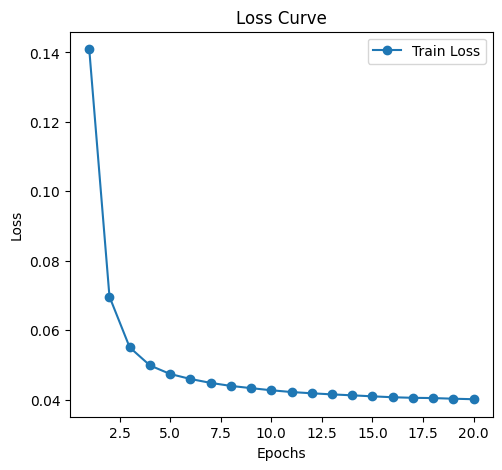

In [ ]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

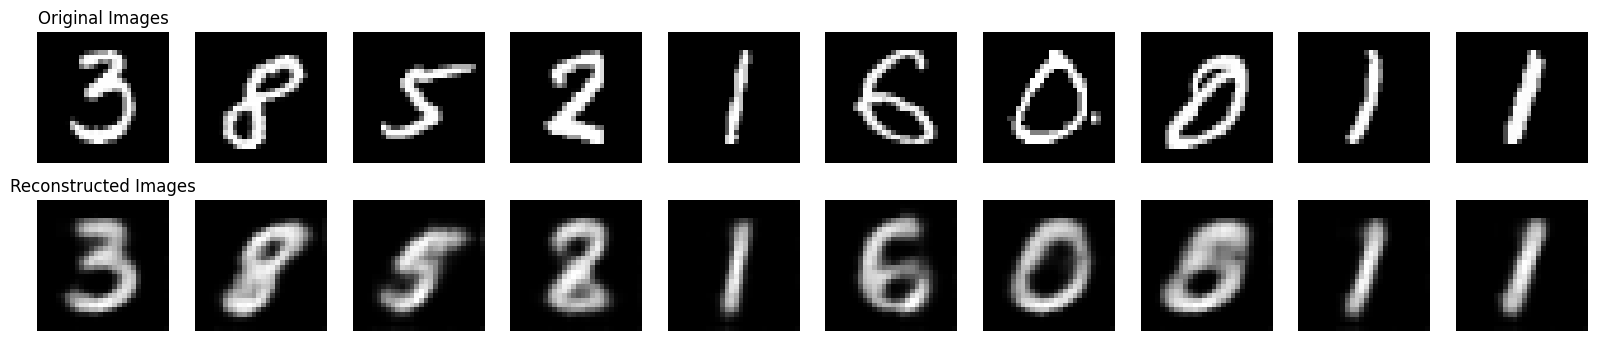

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)  # Select 'num_images' samples

    # Get reconstructed images
    with torch.no_grad():
        _, reconstructions = model(images)
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

# 🔹 Display Results
show_original_vs_reconstructed(model, train_loader, device)


Let's generate some images:

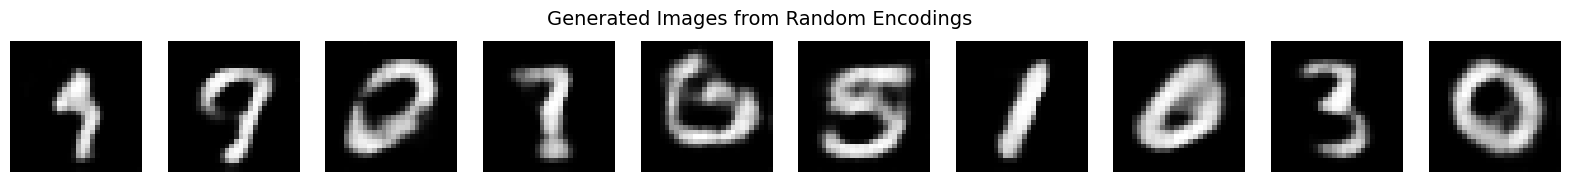

In [ ]:
import matplotlib.pyplot as plt

# 🔹 Function to Generate Images
def generate_images(model, num_images=10, encoding_dim=8):
    model.eval()  # Set to evaluation mode

    # Generate random encodings from a uniform distribution in [-1,1]
    random_encodings = (torch.rand(num_images, encoding_dim).to(device) - 0.5) * 2#[-1,1] we used Tanh, and 8 numbers fromencoding dimension , then 10 images

    # Pass through decoder to generate images
    with torch.no_grad():
        generated_images = model.decoder(random_encodings).cpu()

    # Reshape images
    generated_images = generated_images.view(-1, 28, 28)  # Convert to 2D shape

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    plt.suptitle("Generated Images from Random Encodings", fontsize=14)
    plt.show()

# 🔹 Generate & Display Images
generate_images(model, num_images=10, encoding_dim=8)


Close Enough :)

## **🔹 Exercise: Effect of Encoding Dimension on Reconstruction**
The **encoding dimension** controls how much information is compressed in the latent space.

### **📝 Task**
- Try running the model with **different `encoding_dim` values** (e.g., `1, 2, 128, 256`).
- Observe how the quality of the **reconstructed images** changes.

### Contributed by: Mohamed Eltayeb